# masking

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from plantclef.spark import get_spark

spark = get_spark(
    cores=6,
    memory="16g",
)
display(spark)

25/02/27 17:24:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Thu Feb 27 05:05:31 PM EST 2025


In [11]:
# Path and dataset names
scratch_data_path = f"{root}/scratch/plantclef/data/"
project_data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data"

# Define the path to the train and test parquet files
mask_path = f"{project_data_path}/masking/test_2024_subset20"
test_path = f"{project_data_path}/parquet/test_2024"

# Read the parquet files into a spark DataFrame
mask_df = spark.read.parquet(mask_path)
test_df = spark.read.parquet(test_path)

# Show the data
mask_df.printSchema()
mask_df.show(vertical=True, truncate=100, n=1)
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- leaf_mask: binary (nullable = true)
 |-- flower_mask: binary (nullable = true)
 |-- plant_mask: binary (nullable = true)
 |-- sand_mask: binary (nullable = true)
 |-- wood_mask: binary (nullable = true)
 |-- stone_mask: binary (nullable = true)
 |-- tape_mask: binary (nullable = true)
 |-- tree_mask: binary (nullable = true)
 |-- rock_mask: binary (nullable = true)
 |-- vegetation_mask: binary (nullable = true)
 |-- sample_id: integer (nullable = true)



-RECORD 0---------------------------------------------------------------------------------------------------------------
 image_name      | CBN-PdlC-F2-20160726.jpg                                                                             
 leaf_mask       | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 flower_mask     | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 plant_mask      | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 sand_mask       | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 wood_mask       | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 stone_mask      | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 tape_mask       | [93 4E 55 4D 

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-PdlC-C6-20130...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-Pla-D3-201508...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C3-20190...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C1-20200...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B2-20160...|/test_2024/images...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [12]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = test_df.limit(rows * cols).cache()
mask_subset_df = subset_df.join(mask_df, "image_name").cache()
mask_subset_df.show(n=5)

25/02/27 17:29:32 WARN CacheManager: Asked to cache already cached data.
25/02/27 17:29:32 WARN CacheManager: Asked to cache already cached data.


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|          image_name|                path|                data|           leaf_mask|         flower_mask|          plant_mask|           sand_mask|           wood_mask|          stone_mask|           tape_mask|           tree_mask|           rock_mask|     vegetation_mask|sample_id|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|CBN-PdlC-C6-20130...|/test_2024/images...|[FF D8 FF E0 00 1...|[93 4E 55 4D 50 5...|[93 4E 55 4D 50 5...|[93 4E 55 4D 50 5...|[93 4E 55 4D 50 5.

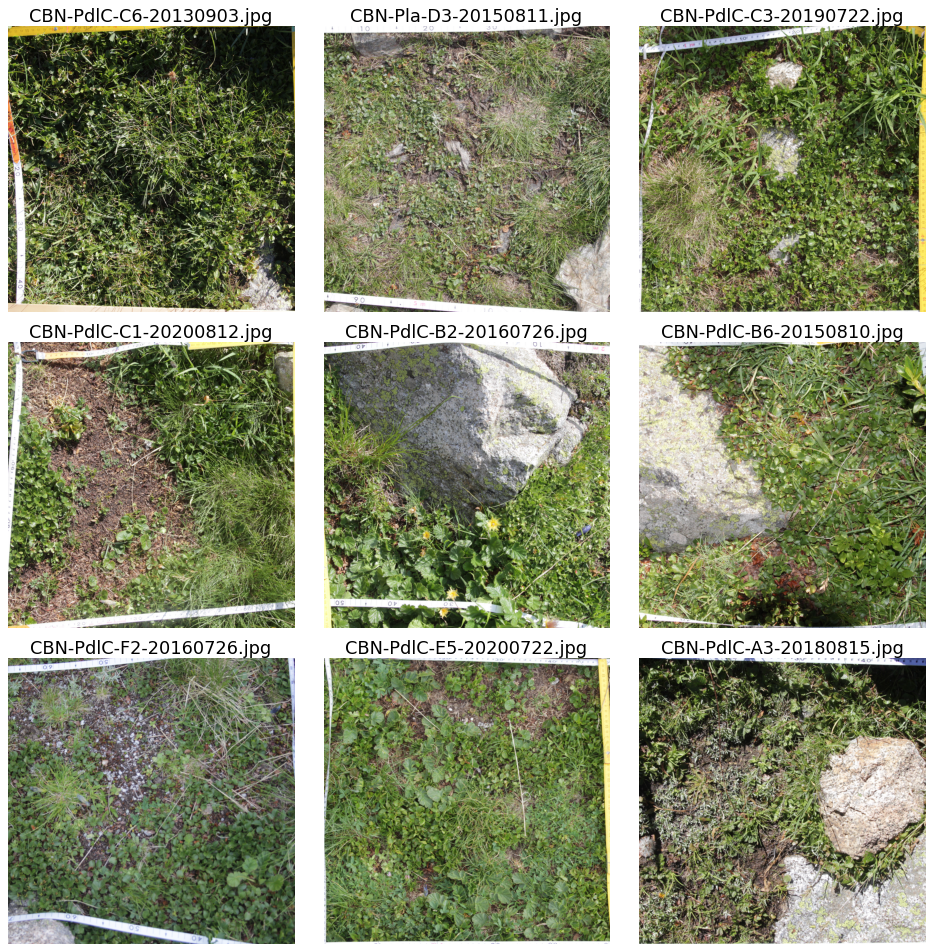

In [6]:
from plantclef.plotting import plot_images_from_binary

# Display the images in a grid with names
plot_images_from_binary(
    mask_subset_df,
    data_col="data",
    label_col="image_name",
    grid_size=(3, 3),
    crop_square=True,
)

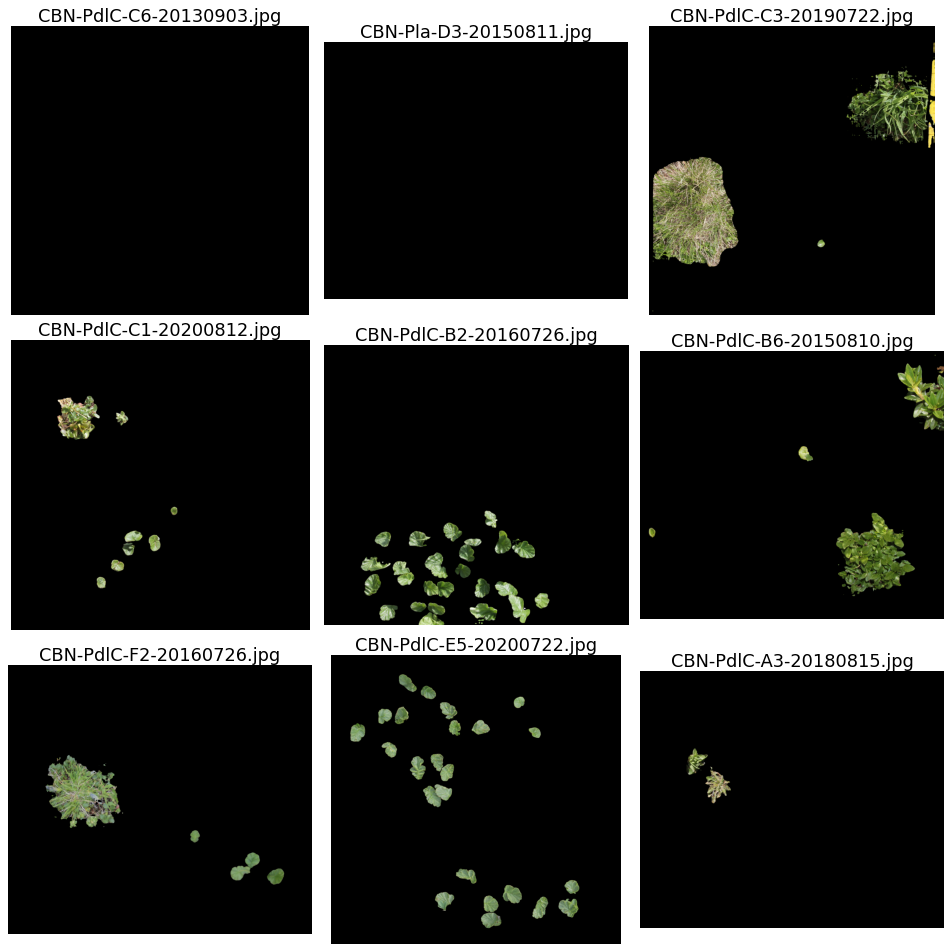

In [7]:
from plantclef.plotting import plot_masks_from_binary

# Display the images in a grid with names
plot_masks_from_binary(
    mask_subset_df,
    image_data_col="data",
    mask_data_col="leaf_mask",
    label_col="image_name",
    grid_size=(3, 3),
    crop_square=True,
)

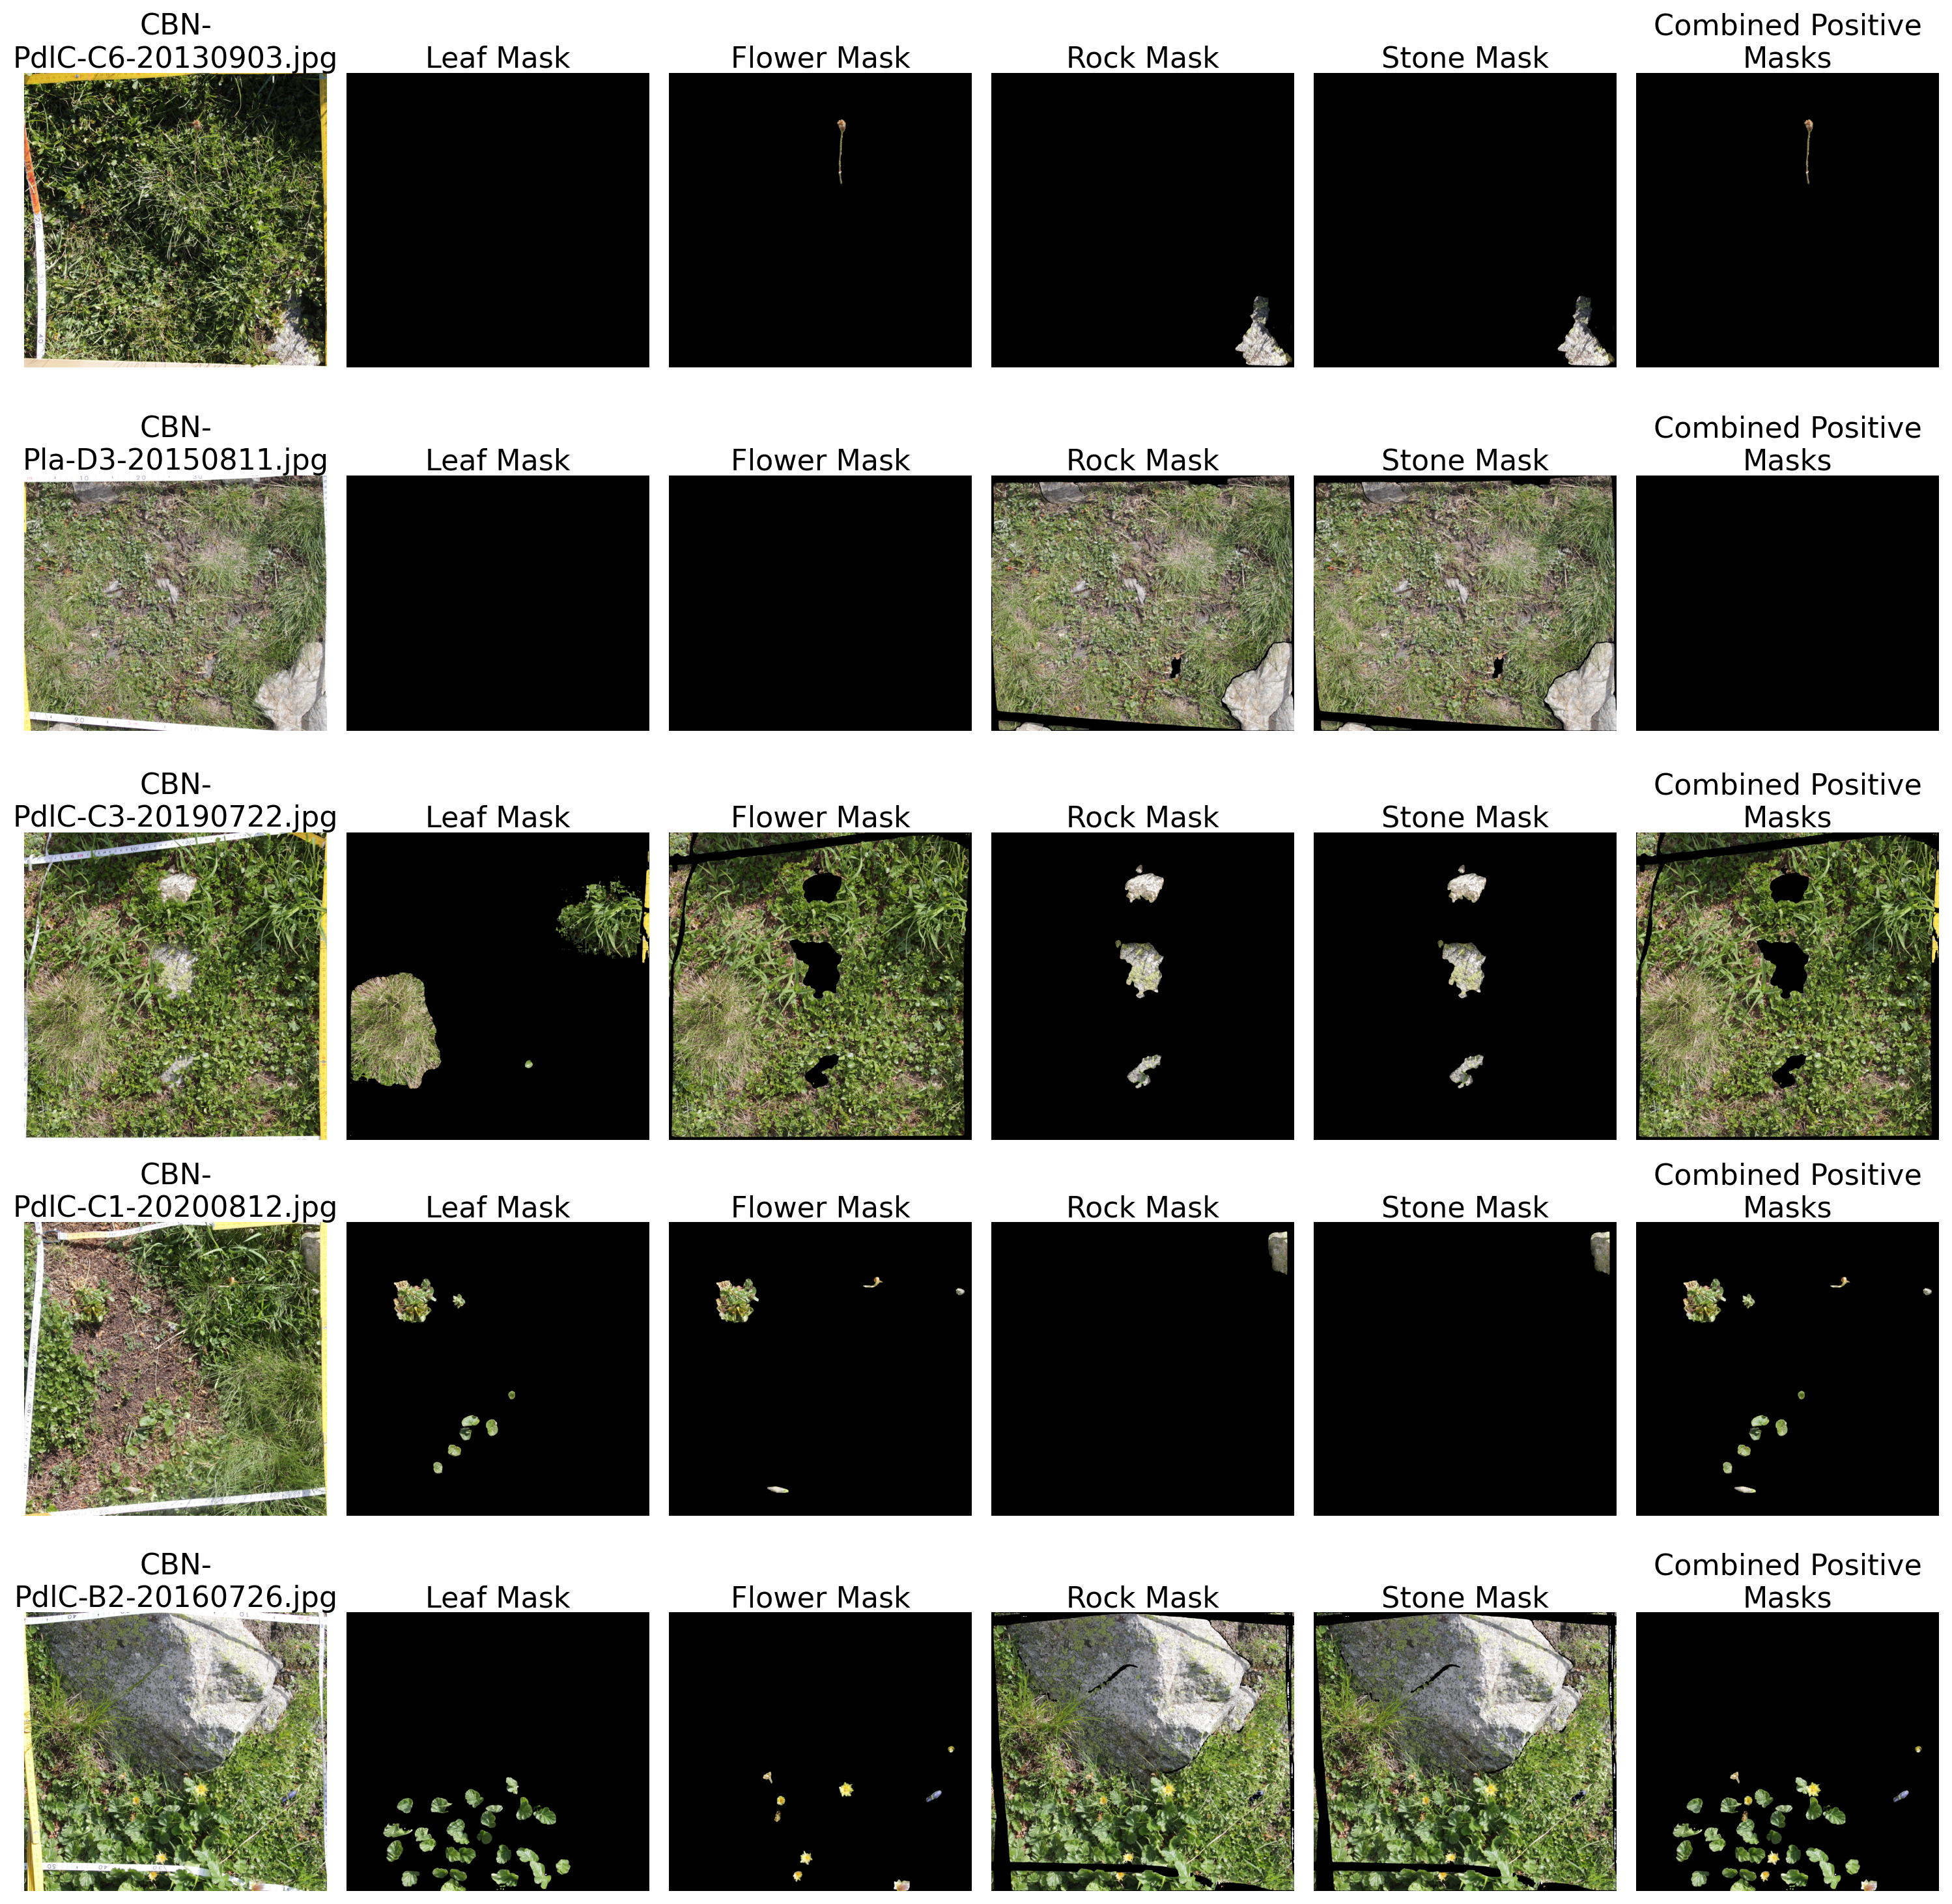

In [26]:
from plantclef.plotting import plot_individual_masks_comparison

# masks we want to display
mask_names = ["leaf_mask", "flower_mask", "rock_mask"]

plot_individual_masks_comparison(
    mask_subset_df,
    mask_names=mask_names,
    label_col="image_name",
    num_rows=5,
    figsize=(15, 15),
    wrap_width=20,
    dpi=200,
)